In [2]:
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, recall_score, precision_score, accuracy_score, roc_curve, auc

Import csv file into pd and remind ourselved how it looks like with .head()

In [3]:
combined_df = pd.read_csv('../data/combined_df_processed.csv')

In [4]:
combined_df.head()

,title,selftext,subreddit
0,new to solo travel post here for introduction...,new are you planning your first big trip to...,0
1,hi can someone tell me how the restrictions w...,syou can delete this if this is isn t suppos...,0
2,is it expensive traveling with a flexible itin...,i m planning my first solo trip hopefully an...,0
3,mistakes whilst travelling solo,i have personally made many mistakes whilst tr...,0
4,weak passport holders how do you travel spont...,so i plan to travel once it is safe to travel ...,0


Split into X and y

In [5]:
#Let's just use 'selftext' for X for now
X = combined_df['selftext']
y = combined_df['subreddit']

In [6]:
#Check the first 5 rows
X.head()

0     new   are you planning your first big trip to...
1     syou can delete this  if this is isn t suppos...
2    i m planning my first solo trip  hopefully  an...
3    i have personally made many mistakes whilst tr...
4    so i plan to travel once it is safe to travel ...
Name: selftext, dtype: object

In [7]:
#A reminder that solotravel = 0, JapanTravel = 1
y.head()

0    0
1    0
2    0
3    0
4    0
Name: subreddit, dtype: int64

## Section 1: Building and scoring baseline model alongside Naive Bayes and Logistic Regression

### Part 1.1: Baseline Model

We need a baseline to compare our models against. A baseline model in this case is simply predicting the majority class.

In [8]:
#Get the normalised value counts to get the percentage
combined_df['subreddit'].value_counts(normalize=True)

1    0.523274
0    0.476726
Name: subreddit, dtype: float64

The classes are almost balanced, with JapanTravel being the majority class. Simply predicting JapanTravel all the time will give you a baseline accuracy of 52%.

### Part 1.2: First Naive Bayes Model with CountVectorizer

In [9]:
#Do the classic train_test_split, stratifying on y because there's slightly imbalanced classes with about 50 more
#JapanTravel than solotravel

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.25,
                                                    random_state=42,
                                                    stratify=y)

In [10]:
# Instantiate our CountVectorizer without stop words to see how well it does
cvec = CountVectorizer(max_features = 500)

In [11]:
# Fit our CountVectorizer on the training data and transform training data.
X_train_cvec = pd.DataFrame(cvec.fit_transform(X_train).toarray(), columns = cvec.get_feature_names())
X_train_cvec.head(3)

,00,03,10,11,12,13,14,15,16,17,...,work,world,worth,would,x200b,year,years,yet,you,your
0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [12]:
# Transform our testing data with the already-fit CountVectorizer.
X_test_cvec = pd.DataFrame(cvec.transform(X_test).toarray(), columns = cvec.get_feature_names())
X_test_cvec.head(3)

,00,03,10,11,12,13,14,15,16,17,...,work,world,worth,would,x200b,year,years,yet,you,your
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


Let's run a multinomial Naive Bayes to classify the posts. We use bernoulli because this is a binary classification problem.

In [13]:
#Instantiate bernoulli Naive Bayes
multi_nb = MultinomialNB()

In [14]:
#Fit the model on X_train_cvec and y_train
model = multi_nb.fit(X = X_train_cvec, y = y_train)

In [15]:
#Predict on X_train_cvec
predictions_nb_train = model.predict(X_train_cvec)

In [16]:
#Predict on X_test_cvec
predictions_nb_test = model.predict(X_test_cvec)

In [17]:
# Score our model on the training set.
model.score(X_train_cvec, y_train)

0.8600999286224126

In [18]:
# Score our model on the testing set.
model.score(X_test_cvec, y_test)

0.8461538461538461

There seems to be low variance and high bias in this case as the scores only differ at the 3rd decimal place.

Let's run another classification algorithm like logistic regression.

### Part 1.3: Building a Logistic Regression model to compare with first Naive Bayes model

In [19]:
#Set LogisticRegression parameters
lr_params = {'penalty':['elasticnet'], 
             'random_state': [42],
             'solver':['saga'],
             'l1_ratio': np.arange(0.1, 1, 0.05),
             'multi_class':['ovr'],
            'max_iter':[150]}
             

In [20]:
#Do gridsearch
lr_gridsearch = GridSearchCV(LogisticRegression(), param_grid = lr_params, verbose=1, cv=5, n_jobs = -1)

In [21]:
#Fitting the gridsearch model on X_train_cvec and y_train
lr_model = lr_gridsearch.fit(X_train_cvec, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   18.7s finished
C:\Users\junho\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


In [22]:
#Predicting the training and test scores respectively
predictions_lr_train = lr_model.predict(X_train_cvec)
predictions_lr_test = lr_model.predict(X_test_cvec)

In [23]:
# Score our model on the training set.
lr_model.score(X_train_cvec, y_train)

0.8893647394718058

In [24]:
# Score our model on the test set.
lr_model.score(X_test_cvec, y_test)

0.8739316239316239

Logistic Regression seems to have even lower bias, though with a slightly increased variance. However, this trade-off is for the better, as variance only increased slightly, while bias dropped by a large amount.

Let's generate confusion matrixes for the results

The first 2 for the test results, naive bayes and logistic regression respectively.

The last 2 for the training results, naive bayes and logistic regression respectively.

In [25]:
#Define a function for easy scoring for both train and test scores
def test_confusion_score(predictions):
    print(confusion_matrix(y_test, predictions))
    print('')
    
    tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()

    print("True Negatives: %s" % tn)
    print("False Positives: %s" % fp)
    print("False Negatives: %s" % fn)
    print("True Positives: %s" % tp)
    print('')
    
    print(f"Accuracy: {accuracy_score(y_test, predictions)}")
    print(f"Recall: {recall_score(y_test,predictions)}")
    print(f"Precision: {precision_score(y_test, predictions)}")
    
def train_confusion_score(predictions):
    print(confusion_matrix(y_train, predictions))
    print('')
    
    tn, fp, fn, tp = confusion_matrix(y_train, predictions).ravel()

    print("True Negatives: %s" % tn)
    print("False Positives: %s" % fp)
    print("False Negatives: %s" % fn)
    print("True Positives: %s" % tp)
    print('')
    
    print(f"Accuracy: {accuracy_score(y_train, predictions)}")
    print(f"Recall: {recall_score(y_train,predictions)}")
    print(f"Precision: {precision_score(y_train, predictions)}")

In [26]:
# Generate a confusion matrix for naive bayes test results
print("Confusion matrix for naive bayes test results:")
print('')
test_confusion_score(predictions_nb_test)

Confusion matrix for naive bayes test results:

[[210  13]
 [ 59 186]]

True Negatives: 210
False Positives: 13
False Negatives: 59
True Positives: 186

Accuracy: 0.8461538461538461
Recall: 0.7591836734693878
Precision: 0.9346733668341709


In [27]:
# Generate a confusion matrix for logistic regression test results
print("Confusion matrix for logistic regression test results:")
print('')
test_confusion_score(predictions_lr_test)

Confusion matrix for logistic regression test results:

[[207  16]
 [ 43 202]]

True Negatives: 207
False Positives: 16
False Negatives: 43
True Positives: 202

Accuracy: 0.8739316239316239
Recall: 0.8244897959183674
Precision: 0.926605504587156


In [28]:
#Confusion matrix for naive bayes training results
print("Confusion matrix for naive bayes training results:")
print('')
train_confusion_score(predictions_nb_train)

Confusion matrix for naive bayes training results:

[[649  19]
 [177 556]]

True Negatives: 649
False Positives: 19
False Negatives: 177
True Positives: 556

Accuracy: 0.8600999286224126
Recall: 0.7585266030013642
Precision: 0.9669565217391304


In [29]:
#Generate a confusion matrix for logistic regression training results
print("Confusion matrix for logistic regression training results:")
print('')
train_confusion_score(predictions_lr_train)

Confusion matrix for logistic regression training results:

[[632  36]
 [119 614]]

True Negatives: 632
False Positives: 36
False Negatives: 119
True Positives: 614

Accuracy: 0.8893647394718058
Recall: 0.8376534788540245
Precision: 0.9446153846153846


#### What these labels mean

Remember that solotravel = 0, JapanTravel = 1,

**True Negatives** refers to solotravel posts that were correctly classified as solotravel posts (correctly labelled as 0)

**False Positives** refers to solotravel posts that were wrongly classified as JapanTravel posts (wrongly labelled as 1)

**False Negatives** refers to JapanTravel posts that were wrongly classified as solotravel posts (wrongly labelled as 0)

**True Positives** refers to JapanTravel posts that were correctly classified as JapanTravel posts (correctly labelled as 0)


**Accuracy** refers to how many posts from both subreddits were corrrectly classified

**Recall** refers to how many JapanTravel posts truly were classified as JapanTravel posts as a ratio.

**Precision** refers to the number of posts that were classified as JapanTravel were actually from the JapanTravel subreddit.

Both classifiers had more False Negatives than False Positives, which means that both classifiers had more trouble classifying JapanTravel posts as JapanTravel posts. We can see this in the lower recall than precision, meaning that more JapanTravel posts were classified as solotravel (lower recall), than solotravel posts being classified as JapanTravel (higher precision)

As we saw in our exploration in the last notebook, solotravel posts uses fewer words and fewer unique words. It's possible that these False Negatives happen because these JapanTravel posts are shorter, with fewer words unique to JapanTravel.

Logistic Regression did better than Naive Bayes. This is potentially because the Logistic Regression I ran had feature selection built into it as I used the 'elasticnet' version of Logistic Regression. This means that the most significant features (words) were given more weight than the less significant ones.

I also did not attempt to improve the posts any further by removing stop words or attempt lemmatization or stemming.

We can treat this Naive Bayes classifier as a baseline and attempt some stemming and remove the stop words to see if it improves the score.

Let's improve the posts and see how much of an effect it has on Naive Bayes.

## Section 2: Attempting to build better models with different versions of CountVectorizer

### Part 2.1: CountVectorizer removing stop words, max_df of 0.95, and min_df of 2

In [30]:
# Instantiate our CountVectorizer with stop words, a min_df of 2 to remove very rare words, and 
# a max_df of 0.95 to see how well it does
cvec = CountVectorizer(max_features = 500, stop_words= 'english', max_df = 0.95, min_df = 2)

In [31]:
# Apply cvec to the X_train and X_test splits
X_train_improved = pd.DataFrame(cvec.fit_transform(X_train).toarray(), columns = cvec.get_feature_names())
X_test_improved = pd.DataFrame(cvec.fit_transform(X_test).toarray(), columns = cvec.get_feature_names())

In [32]:
#Let's define a function for the bernoulli and logistic model for future use
def multi_model(instantiated_multi, X_train, X_test):
    #Fit the model on X_train and y_train
    model = instantiated_multi.fit(X = X_train, y = y_train)
    
    #Predict for both train and test scores
    predictions_nb_train = model.predict(X_train)
    predictions_nb_test = model.predict(X_test)
    
    return model, predictions_nb_train, predictions_nb_test

def lr_model(X_train, X_test):
    
    #Same parameters as the one above. I can think of no reason why we would want to change this.
    lr_params = {'penalty':['elasticnet'], 
             'random_state': [42],
             'solver':['saga'],
             'l1_ratio': np.arange(0.1, 1, 0.05),
             'multi_class':['ovr'],
            'max_iter':[150]}
    
    #Use gridsearch to iterate through the params. This is for the l1_ratio variable
    lr_gridsearch = GridSearchCV(LogisticRegression(), param_grid = lr_params, verbose=1, cv=5, n_jobs = -1)
    
    #Fit the model
    lr_model = lr_gridsearch.fit(X_train, y_train)
    
    #Predict for both train and test scores
    predictions_lr_train = lr_model.predict(X_train)
    predictions_lr_test = lr_model.predict(X_test)
    
    return lr_model, predictions_lr_train, predictions_lr_test

In [33]:
#Instantiating a new model
multi_nb_improved = MultinomialNB()

In [34]:
#Using bernoulli_model function to get the fitted model and prediction scores
multinom_model, predictions_nb_improved_train, predictions_nb_improved_test = multi_model(multi_nb_improved,
                                                                                              X_train_improved,
                                                                                              X_test_improved)

In [35]:
#Scoring the model on training set by comparing it to y_train
multinom_model.score(X_train_improved, y_train)

0.8736616702355461

In [36]:
#Scoring the model on test set by comparing it to y_test
multinom_model.score(X_test_improved, y_test)

0.6111111111111112

In [37]:
print("Confusion matrix for naive bayes test results with new count vectorizer:")
print('')
test_confusion_score(predictions_nb_improved_test)

Confusion matrix for naive bayes test results with new count vectorizer:

[[ 54 169]
 [ 13 232]]

True Negatives: 54
False Positives: 169
False Negatives: 13
True Positives: 232

Accuracy: 0.6111111111111112
Recall: 0.9469387755102041
Precision: 0.5785536159600998


In [38]:
print("Confusion matrix for naive bayes train results with new count vectorizer:")
print('')
train_confusion_score(predictions_nb_improved_train)

Confusion matrix for naive bayes train results with new count vectorizer:

[[643  25]
 [152 581]]

True Negatives: 643
False Positives: 25
False Negatives: 152
True Positives: 581

Accuracy: 0.8736616702355461
Recall: 0.7926330150068213
Precision: 0.9587458745874587


Variance has increased dramatically! We were better off without the changes to countvectorizer! Also note the large difference in precision and recall in the test results, with precision being at 57%, meaning many solotravel posts were classified as JapanTravel posts!

In [39]:
#Using lr_model function to get the fitted model and prediction scores
lr_model_improved, predictions_lr_improved_train, predictions_lr_improved_test = lr_model(X_train_improved,
                                                                                         X_test_improved)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   14.8s finished
C:\Users\junho\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


In [40]:
# Score on the improved X_train data
lr_model_improved.score(X_train_improved, y_train)

0.9464668094218416

In [41]:
# Score on the improved y_test data
lr_model_improved.score(X_test_improved, y_test)

0.6004273504273504

In [42]:
print("Confusion matrix for logistic regression test results with new count vectorizer:")
print('')
test_confusion_score(predictions_lr_improved_test)

Confusion matrix for logistic regression test results with new count vectorizer:

[[158  65]
 [122 123]]

True Negatives: 158
False Positives: 65
False Negatives: 122
True Positives: 123

Accuracy: 0.6004273504273504
Recall: 0.5020408163265306
Precision: 0.6542553191489362


In [43]:
print("Confusion matrix for logistic regression train results with new count vectorizer:")
print('')
train_confusion_score(predictions_lr_improved_train)

Confusion matrix for logistic regression train results with new count vectorizer:

[[660   8]
 [ 67 666]]

True Negatives: 660
False Positives: 8
False Negatives: 67
True Positives: 666

Accuracy: 0.9464668094218416
Recall: 0.9085948158253752
Precision: 0.9881305637982196


Logistic Regression is dramatically overfitting in this case, with a 30% difference in accuracy score between training and test sets! We can also see this difference in the above confusion matrixes, with the training score only having 8 False Positives, which is around 1% of the Negative scores. However, in the test set, there were 65 False Positives, which is about a quarter of the Negative scores!

Precision and Recall fell dramatically, with about a 40% difference in Recall and 30% in Precision!

Let's try one more countvectorizer, this time just removing the stop words.

### Part 2.2: CountVectorizer removing stop words only

In [44]:
# Final cvec just without stop words
cvec = CountVectorizer(max_features = 500, stop_words= 'english')

# Apply cvec to the X_train and X_test splits
X_train_no_stop = pd.DataFrame(cvec.fit_transform(X_train).toarray(), columns = cvec.get_feature_names())
X_test_no_stop = pd.DataFrame(cvec.fit_transform(X_test).toarray(), columns = cvec.get_feature_names())

In [45]:
#Instantiating a new bernoulli model
multi_nb_no_stop = MultinomialNB()

In [46]:
# Using bernoulli_model function to get the model and prediction scores
multi_no_stop_model, predictions_nb_no_stop_train, predictions_nb_no_stop_test = multi_model(multi_nb_no_stop,
                                                                                              X_train_no_stop,
                                                                                              X_test_no_stop)

In [47]:
# Using the model to score on X_train_no_stop
multi_no_stop_model.score(X_train_no_stop, y_train)

0.8736616702355461

In [48]:
# Using the model to score on X_test_no_stop
multi_no_stop_model.score(X_test_no_stop, y_test)

0.6025641025641025

Again, it seems there has been an increase in variance compared to the original model

In [49]:
#Using lr_model function to get the fitted model and prediction scores
lr_model_no_stop, predictions_lr_no_stop_train, predictions_lr_no_stop_test = lr_model(X_train_no_stop,
                                                                                         X_test_no_stop)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   14.9s finished
C:\Users\junho\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


In [50]:
# Score on the X_train_no_stop data
lr_model_no_stop.score(X_train_no_stop, y_train)

0.9457530335474661

In [51]:
# Score on the X_test_no_stop data
lr_model_no_stop.score(X_test_no_stop, y_test)

0.594017094017094

This is the worst version of the logistic regression model so far. There is no need to see the confusion matrix because of just how bad the test score is. It's slightly better than the baseline accuracy score.

## Section 3: Lemmatizing, using TfidfVectorizer, and using Topics

So far I have been using CountVectorizer to vectorize the words. We have learnt that removing stop words is counter-productive for accuracy.

In this section, I move on to using Tf-idf to vectorize the words. I will also use topics.

### Part 3.1: Lemmatizing the words and using Tf-idf vectorizer

In [52]:
#Create a 'title_text' column that is a combination of 'title' and 'selftext' so it
#can be fed to the vectorizer
combined_df['title_text'] = combined_df['title'] + combined_df['selftext']
combined_df['title_text'].head()

0    new to solo travel  post here for introduction...
1    hi  can someone tell me how the restrictions w...
2    is it expensive traveling with a flexible itin...
3    mistakes whilst travelling soloi have personal...
4    weak passport holders  how do you travel spont...
Name: title_text, dtype: object

In [53]:
#Lemmatize 'title_text'
lemmatizer = WordNetLemmatizer()
lemmatized = [[lemmatizer.lemmatize(word) for word in word_tokenize(s)]
              for s in combined_df['title_text']]

In [54]:
#Create a new column for the lemmatized text
combined_df['title_text_lemmatized'] = lemmatized
combined_df['title_text_lemmatized'].head()

0    [new, to, solo, travel, post, here, for, intro...
1    [hi, can, someone, tell, me, how, the, restric...
2    [is, it, expensive, traveling, with, a, flexib...
3    [mistake, whilst, travelling, soloi, have, per...
4    [weak, passport, holder, how, do, you, travel,...
Name: title_text_lemmatized, dtype: object

In [55]:
#Define a function to convert the list of words into a string
def converttostr(input_seq, seperator=' '):
    # Join all the strings in list
    final_str = seperator.join(input_seq)
    return (final_str)

In [56]:
#Apply function to series
combined_df['title_text_lemmatized'] = combined_df['title_text_lemmatized'].apply(converttostr)

In [57]:
#Reinstantiate X and y. 
X = combined_df['title_text_lemmatized']
y = combined_df['subreddit']

In [58]:
#Split into X and y train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.25,
                                                    random_state=42,
                                                    stratify=y)

In [59]:
# Instantiate our Tf-idf vectorizer without stop words
tfidfvec = TfidfVectorizer(max_features=500)

In [60]:
# Fit and transform and save the transformed training data into a dataframe
X_train_tfidf = pd.DataFrame(tfidfvec.fit_transform(X_train).toarray(), columns = tfidfvec.get_feature_names())
X_train_tfidf.head(3)

,00,03,10,11,12,13,14,15,16,17,...,wondering,work,world,worth,would,x200b,year,yet,you,your
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.135446,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.203881,0.0,0.142140,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.089331,0.0


In [61]:
# Transform our testing data with the already-fit tfidfvec
X_test_tfidf = pd.DataFrame(tfidfvec.transform(X_test).toarray(), columns = tfidfvec.get_feature_names())
X_test_tfidf.head(3)

,00,03,10,11,12,13,14,15,16,17,...,wondering,work,world,worth,would,x200b,year,yet,you,your
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.073058,0.109939
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.050575,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.025632,0.000000


### Part 3.2: Using Naive Bayes

In [62]:
#Instantiating a Multinomial Naive Bayesmodel
multi_nb_tfidf = MultinomialNB()

In [63]:
# Run the Multinomial Naive Bayes model
multi_nb_tfidf, predictions_nb_tfidf_train, predictions_nb_tfidf_test = multi_model(multi_nb_tfidf,
                                                                                              X_train_tfidf,
                                                                                              X_test_tfidf)

In [64]:
# Multinomial Naive Bayes training score
multi_nb_tfidf.score(X_train_tfidf, y_train)

0.9172019985724482

In [65]:
# Multinomial Naive Bayes test score
multi_nb_tfidf.score(X_test_tfidf, y_test)

0.9123931623931624

In [66]:
print("Confusion matrix for naive bayes test results with tfidf and word lemmatization:")
print('')
test_confusion_score(predictions_nb_tfidf_test)

Confusion matrix for naive bayes test results with tfidf and word lemmatization:

[[211  12]
 [ 29 216]]

True Negatives: 211
False Positives: 12
False Negatives: 29
True Positives: 216

Accuracy: 0.9123931623931624
Recall: 0.8816326530612245
Precision: 0.9473684210526315


In [67]:
print("Confusion matrix for naive bayes train results with tfidf and word lemmatization:")
print('')
train_confusion_score(predictions_nb_tfidf_train)

Confusion matrix for naive bayes train results with tfidf and word lemmatization:

[[648  20]
 [ 96 637]]

True Negatives: 648
False Positives: 20
False Negatives: 96
True Positives: 637

Accuracy: 0.9172019985724482
Recall: 0.869031377899045
Precision: 0.969558599695586


We see that both bias and variance have massively dropped! We have reached 91% accuracy. Note that False Negatives are still higher than False Positives, so JapanTravel posts are still more commonly mis-classified as solotravel posts than vice versa.

### Part 3.2: Using Logistic Regression

In [68]:
# Run the Logistic Regression model on the training and test sets
lr_model_tfidf, predictions_lr_tfidf_train, predictions_lr_tfidf_test = lr_model(X_train_tfidf,
                                                                                         X_test_tfidf)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    2.1s finished


In [69]:
# Score on the X_train_tfidf training data
lr_model_tfidf.score(X_train_tfidf, y_train)

0.9607423269093505

In [70]:
# Score on the X_train_tfidf test data
lr_model_tfidf.score(X_test_tfidf, y_test)

0.9487179487179487

In [71]:
print("Confusion matrix for Logistic Regression test results with tfidf and word lemmatization:")
print('')
test_confusion_score(predictions_lr_tfidf_test)

Confusion matrix for Logistic Regression test results with tfidf and word lemmatization:

[[211  12]
 [ 12 233]]

True Negatives: 211
False Positives: 12
False Negatives: 12
True Positives: 233

Accuracy: 0.9487179487179487
Recall: 0.9510204081632653
Precision: 0.9510204081632653


In [72]:
print("Confusion matrix for Logistic Regression train results with tfidf and word lemmatization:")
print('')
train_confusion_score(predictions_lr_tfidf_train)

Confusion matrix for Logistic Regression train results with tfidf and word lemmatization:

[[647  21]
 [ 34 699]]

True Negatives: 647
False Positives: 21
False Negatives: 34
True Positives: 699

Accuracy: 0.9607423269093505
Recall: 0.9536152796725784
Precision: 0.9708333333333333


Let's draw an ROC AUC graph for this model

In [73]:
# Getting the False Positive Rate (fpr), True Positive Rates (tpr), and the threshold
fpr, tpr, threshold = roc_curve(y_test, predictions_lr_tfidf_test)

# Setting the auc curve
roc_auc = auc(fpr, tpr)

Roc curve for this Logistic Regression, ElasticNet model



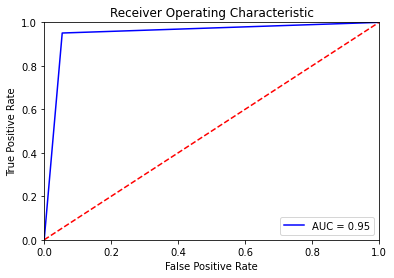

0.9486043744852201


In [74]:
# Getting the ROC AUC curvve
print("Roc curve for this Logistic Regression, ElasticNet model\n")

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)

# Put a legend at the bottom right
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')

# Set up graph window
plt.xlim([0, 1])
plt.ylim([0, 1])

# Set up x and y labels
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

print(roc_auc)

These results are even better than the Naive Bayes model. The same ideas we've found apply here too, with False Negatives being higher than False Positives. However, this Logistic Regression model has reduced the disparity in the two!

The AUC curve represents how well the model did. The larger the area enclosed below the blue line, the better. This means that when the blue line is a right-angled triangle with the right-angle at the top left hand corner, we get a perfect score. This curve has a score of 94.86%, which is the accuracy of the Logistic Regression model predicting on the test set.

Let's save this Logistic Regression model with the Pickle library

In [75]:
# Save into the production_model folder
filename = '../production_model/production_model_lr'
outfile = open(filename,'wb')

In [76]:
# Write the model
pickle.dump(lr_model_tfidf,outfile)
outfile.close()

## Section 4: Analysis

### Part 4.1: Analysing the production model and how we obtained the score we did

### Why did removing stop words make things worse

We saw that removing stop words reduced performance of both classifiers significantly; both bias and variance increased, particularly the variance. As we saw in the data exploration, Question 2 ("How do the shortest strings look like?"), there are a significant number of stop words used in JapanTravel. Its top most frequent word, 'the', is mentioned over 15,000 times, compared to solotravel's use of 'the', which is 3rd most frequent at only 5,000 or so usages. Since these stop words are mentioned around 2-3 times more often in JapanTravel, the presence of stop words gives the models useful information in the form of number of times they are used in a post.

This is further augmented by our analysis in Question 3 ("How do the shortest strings look like?"), Question 5 ("How many unique and non-unique tokens are there?") and Question 6 ("What is the average length of tokens?"), which finds that both subreddits have an average token length of around 3-4, with JapanTravel having 3 times as many tokens. Removing stop words removed a large number of these tokens, giving the models less information to work with.

### How did we manage to get the production model?

#### Adding 'title' to 'selftext' gave the model more information to work with

I think the biggest factor was adding the post titles to the main text, giving both subreddits more information to work with. This is significant because some posts in selftext were empty, which I had replaced with "no_text". There were more posts in solotravel that had no_text compared to JapanTravel, which could explain why there were more False Negatives before title information was added in. Since a title was mandatory, and, as we explored in question 7 ("What are the most common unigrams, bigrams, and trigrams?"), different topics were discussed, the words in the titles would be different from one another.

#### Lemmatizing words increased token frequency

The second factor was lemmatizing words. This reduced different forms of words to its lemma, the 'head word' used in a dictionary. This means there were fewer different versions of words, which increased token frequency. This difference in number is reflected in the different number of words in both subreddits.

#### Tf-idf vectorizer better than Count vectorizer

I initially used CountVectorizer to vectorize the posts. However, I used Tf-idf vectorizer in the final production model. CountVectorizer simply counts the frequency of a word, which means that rare words will be penalised. Tf-idf vectorzier considers the overall weight of words in comparison to each document (post in our case). It weighs words in comparison to how often they appear in documents, so rare words that appear in several documents a few times will still get a good weight.

I also used a max_feature argument of 500, so only the top 500 words were considered. This prevents overfitting.

#### Using ElasticNet prevented overfitting

Remember that we didn't use vanilla Logistic Regression, we used the ElasticNet version of it. This means that it uses a combination of Ridge and Lasso regression, giving weights to the 500 features and sometimes zero-ing them out.

--------------------------------------------------------------------

### Part 4.2: Analysing what we can do with this project

### How can this project help companies?

With a production model in place, companies can now try to scrape new data from the subreddits and apply the production model to the text data. Given an approximately 95% accuracy/recall/precision score, companies will still have to look out for the 5% posts that will not be correctly categorised. More attention will have to be directed towards the solotravel subreddit, where JapanTravel posts are more likely to be categorised in.

The analysis we did in the previous notebook gives companies a sense of topics that both JapanTravel and solotravel are interested in.

### What else can companies do now?

1. Apply this production model to a new set of 25 posts from Reddit's API. They should expect about 4 misclassified posts in a set of 50 from 2 subreddits.

2. Set up a notification system with python which will alert employees to a new post.

3. Use text analysis methodology from the Social Sciences to analyse text from the posts. NLP methods will be needed here, such as using sentiment analysis to find out how people feel about a particular topic.

4. Set up a new production model for other subreddits with these notebooks as a template. Simply replace the variables with the appropriate heading and csv file names.

5. If Logistic Regression with ElasticNet isn't enough, work on another set of classifiers. Some suggestions are a Random Forest classifier and K-Nearest Neighbor.

